In [1]:
import pandas as pd
import numpy as np

# 전력 수요 데이터

In [2]:
elec_demand = pd.read_csv('./data/한국전력거래소_5분단위 전력수급현황_20120601_20230320.csv')
elec_demand = elec_demand.drop(columns='Unnamed: 0')
elec_demand['기준일시'] = pd.to_datetime(elec_demand['기준일시'], format="%Y-%m-%d %H:%M")

elec_demand

,기준일시,공급능력(MW),현재수요(MW),공급예비력(MW),운영예비력(MW)
0,2012-06-01 00:00:00,64355.0,51726.33,12628.67,12628.67
1,2012-06-01 00:05:00,64355.0,51342.53,13012.47,13012.47
2,2012-06-01 00:10:00,64355.0,51583.17,12771.83,12771.83
3,2012-06-01 00:15:00,64355.0,51631.69,12723.31,12723.31
4,2012-06-01 00:20:00,64355.0,51252.66,13102.35,13102.35
...,...,...,...,...,...
1134998,2023-03-20 23:35:00,84398.2,64475.60,19922.60,10068.50
1134999,2023-03-20 23:40:00,84394.6,64211.80,20182.70,10117.80
1135000,2023-03-20 23:45:00,84395.7,63576.80,20818.90,10455.50
1135001,2023-03-20 23:50:00,84384.9,63223.90,21160.90,10446.80


### 현재 수요가 0이 아니면서 다른 값이 0인 경우는 1개의 사례만 있음

In [4]:
elec_demand[(elec_demand['현재수요(MW)'] != 0) & (elec_demand['공급능력(MW)'] == 0)]

,기준일시,공급능력(MW),현재수요(MW),공급예비력(MW),운영예비력(MW)
679454,2018-11-18 11:40:00,0.0,55532.2,-55532.2,-58137.2


In [7]:
elec_demand[(elec_demand['현재수요(MW)'] != 0) & (elec_demand['공급예비력(MW)'] == 0)]

,기준일시,공급능력(MW),현재수요(MW),공급예비력(MW),운영예비력(MW)


In [8]:
elec_demand[(elec_demand['현재수요(MW)'] != 0) & (elec_demand['운영예비력(MW)'] == 0)]

,기준일시,공급능력(MW),현재수요(MW),공급예비력(MW),운영예비력(MW)


### 분석 타겟인 현재 수요만 남기고 다른 컬럼 드랍

In [3]:
elec_demand = elec_demand[['기준일시', '현재수요(MW)']]

### 현재 수요가 0인 값은 상식 선에서 있을 수 없음. 이 값을 NaN으로 대체

In [4]:
elec_demand['현재수요(MW)'] = elec_demand['현재수요(MW)'].replace(0, np.NaN)

C:\Users\jiho\AppData\Local\Temp\ipykernel_18404\314943537.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_demand['현재수요(MW)'] = elec_demand['현재수요(MW)'].replace(0, np.NaN)


In [5]:
# 데이터 자체가 없는 경우(예. 2022년 4월 6일 16:00 데이터가 없는 경우) 아예 '기준일시' 컬럼에 값이 존재하지 않아 빈 곳을 채움)
elec_demand = elec_demand.set_index('기준일시').resample('5T').first().reset_index()

# 일별 NaN값을 조회하기 위해 day 컬럼 생성
elec_demand['day'] = elec_demand['기준일시'].dt.strftime("%Y-%m-%d")

elec_demand = elec_demand.set_index('기준일시')

In [8]:
elec_demand

,현재수요(MW),day
기준일시,,
2012-06-01 00:00:00,51726.33,2012-06-01
2012-06-01 00:05:00,51342.53,2012-06-01
2012-06-01 00:10:00,51583.17,2012-06-01
2012-06-01 00:15:00,51631.69,2012-06-01
2012-06-01 00:20:00,51252.66,2012-06-01
...,...,...
2023-03-20 23:35:00,64475.60,2023-03-20
2023-03-20 23:40:00,64211.80,2023-03-20
2023-03-20 23:45:00,63576.80,2023-03-20


### 아예 집계되지 않은 데이터가 다수 있음을 확인</br>
    - count가 288(24*12(5분 단위))에 근접하는 값들도 있지만, 아예 절반에 가까운 수치를 보이는 날짜도 있음
        - 2022년 4월 28일 데이터는 15시 05분 이전 데이터가 없음
            - EPSIS 상에 데이터가 있어 해당 데이터 사용하면 될 것으로 보임

        - 2022년 4월 27일 데이터는 13시 50분 이후 데이터가 없음
            - EPSIS 상에서도 마찬가지
            - 지난 주, 다음 주, 전후일 데이터를 가지고 추정해야 할 것으로 보임

        - 2022년 4월 6일은 13:40분 이후 데이터 없음
            - EPSIS 상에서도 13:40분 이후 데이터가 없음
            - 지난 주, 다음 주, 전후일 데이터를 가지고 추정해야 할 것으로 보임

        - 2022년 1월 16일은 12시 35분 ~ 15:55분 데이터가 1건 뿐
            - EPSIS 상에서도 마찬가지
            - 지난 주, 다음 주, 전후일 데이터를 가지고 추정해야 할 것으로 보임

        - 2018년 5월 8일은 21:20분 이후 데이터 없음
            - EPSIS 상에서도 마찬가지
            - 지난 주, 다음 주, 전후일 데이터를 가지고 추정해야 할 것으로 보임

In [6]:
# 일별 데이터의 수 확인. 288개의 데이터가 있어야 정상
count = elec_demand.groupby('day').count()
count.sort_values('현재수요(MW)')

,현재수요(MW)
day,
2022-04-28,106
2022-04-06,164
2022-04-27,167
2022-08-16,217
2023-02-17,247
...,...
2016-09-30,288
2016-10-02,288
2016-10-03,288


In [7]:
# 288개보다 값이 적은 값들의 인덱스(연월일시분) 추출
missing_days = count[count['현재수요(MW)'] != 288].sort_values('현재수요(MW)', ascending=True).index

# 현재수요가 NaN인 인덱스(연월일시분) 추출
missing_times = elec_demand[elec_demand['현재수요(MW)'].isna()].index

In [8]:
# 특정 일에 NaN값이 있는 데이터를 조회하는 함수
def checkNaN(df, date):
    valid = df[df['day'] == date]

    return valid[valid['현재수요(MW)'].isna()]

# 연속으로 NaN값이 있는 데이터의 수를 조회하는 함수
def checkConsNaN(df, date):
    valid = df[df['day'] == date].reset_index()
    valid = valid[valid['현재수요(MW)'].isna()]
    valid['time'] = (valid['기준일시'].dt.hour*100 + valid['기준일시'].dt.minute).astype(int)
    valid['diff'] = valid['time'].diff()
    valid['diff'] = valid['diff'].fillna(0)

    cons = valid[valid['diff']==5]['diff'].count()
    not_cons = valid[valid['diff']!=5]['diff'].count()

    return date, cons, not_cons

In [13]:
checkConsNaN(elec_demand, '2022-04-06')

('2022-04-06', 112, 12)

### NaN값이 있는 날 중, 총 NaN값의 수, 연속된 NaN값의 수, 불연속적인 NaN값의 수

In [14]:
list = []
for date in missing_days:
    tmp_dict = {}
    data = checkConsNaN(elec_demand, date)
    tmp_dict['date'] = data[0]
    tmp_dict['totalNa'] = data[1] + data[2]
    tmp_dict['consecutive'] = data[1]
    tmp_dict['inconsecutive'] = data[2]

    list.append(tmp_dict)

missing_cons = pd.DataFrame(list)
missing_cons

,date,totalNa,consecutive,inconsecutive
0,2022-04-28,182,166,16
1,2022-04-06,124,112,12
2,2022-04-27,121,110,11
3,2022-08-16,71,64,7
4,2023-02-17,41,14,27
...,...,...,...,...
724,2019-07-27,1,0,1
725,2019-06-21,1,0,1
726,2019-05-17,1,0,1
727,2019-01-19,1,0,1


In [19]:
missing_cons.sort_values('consecutive', ascending=False).head(30)

,date,totalNa,consecutive,inconsecutive
0,2022-04-28,182,166,16
1,2022-04-06,124,112,12
2,2022-04-27,121,110,11
3,2022-08-16,71,64,7
5,2022-01-16,39,34,5
7,2018-05-08,32,29,3
8,2023-02-19,31,17,14
9,2023-02-09,26,17,9
4,2023-02-17,41,14,27
17,2023-01-16,18,14,4


In [20]:
missing_cons['totalNa'].sum()

2453

In [21]:
elec_demand[elec_demand['현재수요(MW)'].isna()]

,현재수요(MW),day
기준일시,,
2012-06-01 05:30:00,NaN,2012-06-01
2012-06-01 07:00:00,NaN,2012-06-01
2012-06-01 10:55:00,NaN,2012-06-01
2012-06-01 16:45:00,NaN,2012-06-01
2012-06-01 20:00:00,NaN,2012-06-01
...,...,...
2023-03-16 00:50:00,NaN,2023-03-16
2023-03-16 08:35:00,NaN,2023-03-16
2023-03-16 08:45:00,NaN,2023-03-16


In [22]:
elec_demand

,현재수요(MW),day
기준일시,,
2012-06-01 00:00:00,51726.33,2012-06-01
2012-06-01 00:05:00,51342.53,2012-06-01
2012-06-01 00:10:00,51583.17,2012-06-01
2012-06-01 00:15:00,51631.69,2012-06-01
2012-06-01 00:20:00,51252.66,2012-06-01
...,...,...
2023-03-20 23:35:00,64475.60,2023-03-20
2023-03-20 23:40:00,64211.80,2023-03-20
2023-03-20 23:45:00,63576.80,2023-03-20


# 테스트를 위해 모든 구간의 데이터가 전부 있는 연월일를 추출

In [15]:
not_null_sample = count[count['현재수요(MW)'] == 288].sample(2000).index

In [17]:
count.index

Index(['2012-06-01', '2012-06-02', '2012-06-03', '2012-06-04', '2012-06-05',
       '2012-06-06', '2012-06-07', '2012-06-08', '2012-06-09', '2012-06-10',
       ...
       '2023-03-11', '2023-03-12', '2023-03-13', '2023-03-14', '2023-03-15',
       '2023-03-16', '2023-03-17', '2023-03-18', '2023-03-19', '2023-03-20'],
      dtype='object', name='day', length=3945)

In [16]:
not_null_sample

Index(['2016-03-25', '2019-07-12', '2019-08-10', '2023-01-06', '2017-04-01',
       '2012-10-18', '2018-11-17', '2013-10-02', '2022-05-15', '2016-06-20',
       ...
       '2018-06-10', '2014-02-06', '2021-08-13', '2014-10-10', '2019-11-22',
       '2022-05-26', '2012-12-30', '2012-12-10', '2014-06-03', '2022-10-18'],
      dtype='object', name='day', length=2000)

In [24]:
elec_demand

,현재수요(MW),day
기준일시,,
2012-06-01 00:00:00,51726.33,2012-06-01
2012-06-01 00:05:00,51342.53,2012-06-01
2012-06-01 00:10:00,51583.17,2012-06-01
2012-06-01 00:15:00,51631.69,2012-06-01
2012-06-01 00:20:00,51252.66,2012-06-01
...,...,...
2023-03-20 23:35:00,64475.60,2023-03-20
2023-03-20 23:40:00,64211.80,2023-03-20
2023-03-20 23:45:00,63576.80,2023-03-20


In [25]:
# 샘플 데이터 추출
sample = elec_demand[elec_demand['day'].isin(not_null_sample)].drop(columns='day')

# 샘플 값에서 정답 데이터를 생성
sample['real_value'] = sample['현재수요(MW)'].copy()

# 현재 수요에 랜덤으로 NaN값 부여(전체 데이터와 샘플 데이터의 크기에 맞추어 NaN 값을 1243개 부여(전체 데이터의 NaN값은 2453개))
sample.rename(columns={'현재수요(MW)':'gen_null'}, inplace=True)
random_row = np.random.choice(sample.index, 1243)  # 무작위로 행 선택
sample.loc[random_row, 'gen_null'] = np.nan
sample[sample['gen_null'].isna()]

,gen_null,real_value
기준일시,,
2012-06-05 05:00:00,NaN,50515.12
2012-06-05 22:30:00,NaN,56750.29
2012-06-08 09:50:00,NaN,61579.88
2012-06-08 17:45:00,NaN,61162.70
2012-06-09 13:40:00,NaN,57524.50
...,...,...
2023-02-03 02:30:00,NaN,66191.80
2023-02-03 08:05:00,NaN,80259.10
2023-02-03 18:20:00,NaN,79258.10


In [26]:
sample[sample['real_value'].isna()]

,gen_null,real_value
기준일시,,


In [27]:
from sklearn.metrics import mean_squared_error

#### 샘플 2000개로 테스트 --> 너무 시간이 오래걸려 보류

In [28]:
# for method in ['nearest', 'linear', 'polynomial', 'spline', 'cubic']:
#     if method in ['polynomial', 'spline']:
#         for order in [2, 3]:
#             sample[method+str(order)] = sample[['gen_null']].interpolate(method=method, order=order).rename(columns={"gen_null":method+str(order)})[method+str(order)]
#             print(method+str(order), 'RMSE', ':', np.sqrt(mean_squared_error(sample[sample['gen_null'].isna()]['real_value'], sample[sample['gen_null'].isna()][method+str(order)])))
#     else:
#         sample[method] = sample[['gen_null']].interpolate(method=method).rename(columns={"gen_null":method})[method]
#         print(method, 'RMSE', ':', np.sqrt(mean_squared_error(sample[sample['gen_null'].isna()]['real_value'], sample[sample['gen_null'].isna()][method])))

### 샘플 100개로 재차 테스트 진행 --> Linear의 RMSE가 가장 낮게 나옴

- 100개의 샘플 날짜(28800 rows)에서 100개의 결측치 부여

In [36]:
not_null_sample = count[count['현재수요(MW)'] == 288].index
not_null_sample100 = np.random.choice(not_null_sample, 100)

In [39]:
sample100 = elec_demand[elec_demand['day'].isin(not_null_sample100)].drop(columns='day')
sample100['real_value'] = sample100['현재수요(MW)'].copy()
sample100.rename(columns={'현재수요(MW)':'gen_null'}, inplace=True)
random_row = np.random.choice(sample100.index, 100)  # 무작위로 행 선택
sample100.loc[random_row, 'gen_null'] = np.nan
sample100[sample100['gen_null'].isna()]

,gen_null,real_value
기준일시,,
2012-08-31 00:25:00,NaN,50328.91
2012-09-26 11:55:00,NaN,59557.08
2012-10-25 18:45:00,NaN,61264.66
2012-11-12 20:55:00,NaN,59700.60
2012-12-23 20:15:00,NaN,60080.62
...,...,...
2022-02-13 08:55:00,NaN,59325.50
2022-02-13 09:55:00,NaN,58208.30
2022-03-10 14:05:00,NaN,66685.00


### 각 보간법 방법론을 돌면서 RMSE 측정

- linear 보간법이 가장 낮은 RMSE를 보였으며, 4~70000 이상의 전력 수요에서 155의 RMSE는 꽤나 낮은 값으로 생각됨

In [41]:
for method in ['nearest', 'linear', 'polynomial', 'spline', 'cubic']:
    if method in ['polynomial', 'spline']:
        for order in [2, 3]:
            sample100[method+str(order)] = sample100[['gen_null']].interpolate(method=method, order=order).rename(columns={"gen_null":method+str(order)})[method+str(order)]
            print(method+str(order), 'RMSE', ':', np.sqrt(mean_squared_error(sample100[sample100['gen_null'].isna()]['real_value'], sample100[sample100['gen_null'].isna()][method+str(order)])))
    else:
        sample100[method] = sample100[['gen_null']].interpolate(method=method).rename(columns={"gen_null":method})[method]
        print(method, 'RMSE', ':', np.sqrt(mean_squared_error(sample100[sample100['gen_null'].isna()]['real_value'], sample100[sample100['gen_null'].isna()][method])))

nearest RMSE : 273.39140205207593
linear RMSE : 155.38822838297622
polynomial2 RMSE : 174.06420510591857
polynomial3 RMSE : 179.05326674050522
spline2 RMSE : 173.90843561418833
spline3 RMSE : 179.0376062181493
cubic RMSE : 179.05326674050522


### 추가 테스트 진행

- 위의 테스트는 결측치를 랜덤으로 부여하여 연속으로 결측치가 있는 경우까지 커버한다고 이야기하기에는 어려움이 있음
- 연속으로 데이터가 비어있는 경우도 확인하기 위해 추가 테스트 진행
- 또한 전의 테스트에서는 날짜를 무작위로 샘플링하여, 2022년 4월 8일 데이터 이후에 2022년 4월 9일이 아닌 4월 11일이 나올 수 있음.
- 이 경우 보간이 제대로 이루어지지 않을 수 있어 이번 테스트는 매 iteration마다 무작위로 날짜를 1개 고르고 100번을 반복

In [ ]:
sample100 = elec_demand[elec_demand['day'].isin(not_null_sample100)].drop(columns='day')
sample100['real_value'] = sample100['현재수요(MW)'].copy()
sample100.rename(columns={'현재수요(MW)':'gen_null'}, inplace=True)
random_row = np.random.choice(sample100.index, 100)  # 무작위로 행 선택
sample100.loc[random_row, 'gen_null'] = np.nan
sample100[sample100['gen_null'].isna()]

In [82]:
import warnings
warnings.filterwarnings(action='ignore')

In [84]:
import numpy as np
import pandas as pd
score_list = []
# 연속 결측치의 크기(연속으로 1개, 연속으로 2개, ... , 연속으로 150개)
for size in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,29,34,64,100,150]:
    #  RMSE 스코어 초기화
    score = {'size':size,'nearest':0, 'linear':0, 'polynomial2':0, 'polynomial3':0, 'spline2':0, 'spline3':0, 'cubic':0}
    for iteration in range(100):
        # 날짜 1개 샘플링
        not_null_sample = count[count['현재수요(MW)'] == 288].index
        not_null_sample1 = np.random.choice(not_null_sample, 1)
        sample100 = elec_demand[elec_demand['day'].isin(not_null_sample1)].drop(columns='day')
        sample100['real_value'] = sample100['현재수요(MW)'].copy()
        sample100.rename(columns={'현재수요(MW)':'gen_null'}, inplace=True)
        sample100 = sample100.reset_index(drop=True)

        # 연속으로 NaN값을 주는 인덱스의 시작점 정의
        # NaN값이 150이라고 가정했을 때, 시작 인덱스가 200이라면 88개의 결측치만 생성할수도 있어, 이에 대한 보정치 적용
        start_index = np.random.randint(1, len(sample100)-size-2)

        # 연속값의 크기
        consecutive_nan_lengths = size -1

        # 연속으로 NaN값을 주는 인덱스의 끝점 정의
        end_index = start_index + consecutive_nan_lengths
        
        # 앞에서 보정을 했지만, 혹시나 싶어서 if문 추가
        if end_index < len(sample100):
            sample100.loc[start_index:end_index, 'gen_null'] = np.nan

            for method in ['nearest', 'linear', 'polynomial', 'spline', 'cubic']:
                if method in ['polynomial', 'spline']:
                    for order in [2, 3]:
                        # 각 iteration의 RMSE를 score에 누적
                        sample100[method+str(order)] = sample100[['gen_null']].interpolate(method=method, order=order).rename(columns={"gen_null":method+str(order)})[method+str(order)]
                        score[method+str(order)] += np.sqrt(mean_squared_error(sample100[sample100['gen_null'].isna()].loc[start_index:end_index, 'real_value'],
                                                                                sample100[sample100['gen_null'].isna()].loc[start_index:end_index, method+str(order)]))
                else:
                    # 각 iteration의 RMSE를 score에 누적
                    sample100[method] = sample100[['gen_null']].interpolate(method=method).rename(columns={"gen_null":method})[method]
                    score[method] += np.sqrt(mean_squared_error(sample100[sample100['gen_null'].isna()].loc[start_index:end_index, 'real_value'],
                                                                                sample100[sample100['gen_null'].isna()].loc[start_index:end_index, method]))
                        
        else:
            sample100.loc[start_index:, 'gen_null'] = np.nan

            for method in ['nearest', 'linear', 'polynomial', 'spline', 'cubic']:
                if method in ['polynomial', 'spline']:
                    for order in [2, 3]:
                        # 각 iteration의 RMSE를 score에 누적
                        sample100[method+str(order)] = sample100[['gen_null']].interpolate(method=method, order=order).rename(columns={"gen_null":method+str(order)})[method+str(order)]
                        score[method+str(order)] += np.sqrt(mean_squared_error(sample100[sample100['gen_null'].isna()].loc[start_index:, 'real_value'],
                                                                                sample100[sample100['gen_null'].isna()].loc[start_index:, method+str(order)]))
                else:
                    # 각 iteration의 RMSE를 score에 누적
                    sample100[method] = sample100[['gen_null']].interpolate(method=method).rename(columns={"gen_null":method})[method]
                    score[method] += np.sqrt(mean_squared_error(sample100[sample100['gen_null'].isna()].loc[start_index:, 'real_value'],
                                                                                sample100[sample100['gen_null'].isna()].loc[start_index:, method]))
    print(score)
    score_list.append(score)


{'size': 1, 'nearest': 23149.459999999985, 'linear': 12661.33999999999, 'polynomial2': 13729.90827200633, 'polynomial3': 14377.742819922882, 'spline2': 13889.848353298854, 'spline3': 14357.357555761795, 'cubic': 14377.742819922882}
{'size': 2, 'nearest': 22055.10031009781, 'linear': 14580.112142568521, 'polynomial2': 17713.43714400834, 'polynomial3': 18099.76653322874, 'spline2': 17953.68663586004, 'spline3': 18087.396526808476, 'cubic': 18099.76653322874}
{'size': 3, 'nearest': 24510.667685215554, 'linear': 16963.936286377626, 'polynomial2': 21940.718436076397, 'polynomial3': 22323.210759276746, 'spline2': 27439.206208020452, 'spline3': 22332.588823408383, 'cubic': 22323.210759276746}
{'size': 4, 'nearest': 28766.766389694276, 'linear': 20542.75187823645, 'polynomial2': 26224.10840548387, 'polynomial3': 26906.376833362854, 'spline2': 38127.82185446663, 'spline3': 26911.03908899857, 'cubic': 26906.376833362854}
{'size': 5, 'nearest': 35343.60014883029, 'linear': 23122.701563225084, 'po

In [93]:
test_result = pd.DataFrame(score_list).set_index('size')

# 누적 값에서 iteration의 크기로 나누어 평균을 취함
test_result = round(test_result / 100, 2)

In [94]:
test_result

,nearest,linear,polynomial2,polynomial3,spline2,spline3,cubic
size,,,,,,,
1,231.49,126.61,137.30,143.78,138.90,143.57,143.78
2,220.55,145.80,177.13,181.00,179.54,180.87,181.00
3,245.11,169.64,219.41,223.23,274.39,223.33,223.23
4,287.67,205.43,262.24,269.06,381.28,269.11,269.06
5,353.44,231.23,320.94,324.57,320.46,324.41,324.57
6,402.93,242.71,333.39,341.41,419.69,341.20,341.41
7,463.34,233.97,363.61,369.64,394.90,373.93,369.64
8,517.01,294.81,413.76,429.51,496.40,652.69,429.51
9,561.77,325.79,426.67,448.16,453.08,447.81,448.16


In [96]:
import matplotlib.pyplot as plt

### 테스트 결과
- linear 방식의 보간이 어느 구간에서나 가장 낮게 나옴
- 그러나 중간에 모든 값을 테스트한건 아니라서 뒤로 갈수록 더욱 선형적인 그래프가 그려짐

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


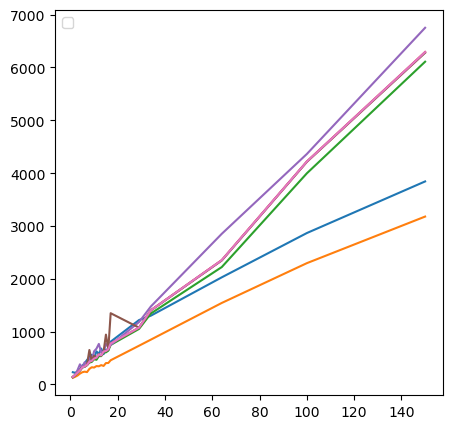

In [106]:
plt.figure(figsize=(5,5))
plt.plot(test_result)
plt.legend()
plt.show()

# 위와 똑같은 방식이지만, 0~150까지의 연속된 값에 NaN을 씌워 테스트 진행

In [105]:
import numpy as np
import pandas as pd
score_list2 = []
for size in range(1,151):
    score = {'size':size,'nearest':0, 'linear':0, 'polynomial2':0, 'polynomial3':0, 'spline2':0, 'spline3':0, 'cubic':0}
    for iteration in range(100):
        not_null_sample = count[count['현재수요(MW)'] == 288].index
        not_null_sample1 = np.random.choice(not_null_sample, 1)
        sample100 = elec_demand[elec_demand['day'].isin(not_null_sample1)].drop(columns='day')
        sample100['real_value'] = sample100['현재수요(MW)'].copy()
        sample100.rename(columns={'현재수요(MW)':'gen_null'}, inplace=True)
        sample100 = sample100.reset_index(drop=True)

        # Randomly select the starting index for consecutive NaN values
        start_index = np.random.randint(1, len(sample100)-size-2)

        # Determine the length of consecutive NaN values
        consecutive_nan_lengths = size -1

        # Set consecutive NaN values at the randomly chosen indices
        end_index = start_index + consecutive_nan_lengths
        if end_index < len(sample100):
            sample100.loc[start_index:end_index, 'gen_null'] = np.nan

            for method in ['nearest', 'linear', 'polynomial', 'spline', 'cubic']:
                if method in ['polynomial', 'spline']:
                    for order in [2, 3]:
                        sample100[method+str(order)] = sample100[['gen_null']].interpolate(method=method, order=order).rename(columns={"gen_null":method+str(order)})[method+str(order)]
                        score[method+str(order)] += np.sqrt(mean_squared_error(sample100[sample100['gen_null'].isna()].loc[start_index:end_index, 'real_value'],
                                                                                sample100[sample100['gen_null'].isna()].loc[start_index:end_index, method+str(order)]))
                else:
                    sample100[method] = sample100[['gen_null']].interpolate(method=method).rename(columns={"gen_null":method})[method]
                    score[method] += np.sqrt(mean_squared_error(sample100[sample100['gen_null'].isna()].loc[start_index:end_index, 'real_value'],
                                                                                sample100[sample100['gen_null'].isna()].loc[start_index:end_index, method]))
                        
        else:
            sample100.loc[start_index:, 'gen_null'] = np.nan

            for method in ['nearest', 'linear', 'polynomial', 'spline', 'cubic']:
                if method in ['polynomial', 'spline']:
                    for order in [2, 3]:
                        sample100[method+str(order)] = sample100[['gen_null']].interpolate(method=method, order=order).rename(columns={"gen_null":method+str(order)})[method+str(order)]
                        score[method+str(order)] += np.sqrt(mean_squared_error(sample100[sample100['gen_null'].isna()].loc[start_index:, 'real_value'],
                                                                                sample100[sample100['gen_null'].isna()].loc[start_index:, method+str(order)]))
                else:
                    sample100[method] = sample100[['gen_null']].interpolate(method=method).rename(columns={"gen_null":method})[method]
                    score[method] += np.sqrt(mean_squared_error(sample100[sample100['gen_null'].isna()].loc[start_index:, 'real_value'],
                                                                                sample100[sample100['gen_null'].isna()].loc[start_index:, method]))
    print(score)
    score_list2.append(score)


{'size': 1, 'nearest': 20707.390000000014, 'linear': 12524.324999999975, 'polynomial2': 13402.399367507387, 'polynomial3': 13738.003179094543, 'spline2': 13392.207182824, 'spline3': 13737.06586104074, 'cubic': 13738.003179094543}
{'size': 2, 'nearest': 23694.738102063005, 'linear': 16263.119007383402, 'polynomial2': 19305.444577792667, 'polynomial3': 19370.114066141345, 'spline2': 20263.124258279582, 'spline3': 6011802.210816745, 'cubic': 19370.114066141345}
{'size': 3, 'nearest': 27319.516209084577, 'linear': 15838.33517387493, 'polynomial2': 19788.01048429788, 'polynomial3': 20759.11434669641, 'spline2': 20752.150990832444, 'spline3': 23274.622357595217, 'cubic': 20759.11434669641}
{'size': 4, 'nearest': 31430.9020811772, 'linear': 19402.84488609004, 'polynomial2': 25593.856086698783, 'polynomial3': 26360.6639720526, 'spline2': 25546.665906926028, 'spline3': 26329.14764490632, 'cubic': 26360.6639720526}
{'size': 5, 'nearest': 37575.93685772302, 'linear': 21680.300680344, 'polynomial2

In [118]:
test_result2 = pd.DataFrame(score_list2)
test_result2 = round(test_result2 / 100, 2)

In [119]:
test_result2.describe()

,size,nearest,linear,polynomial2,polynomial3,spline2,spline3,cubic
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,1.500000e+02,150.000000
mean,0.755000,2326.731600,1826.696733,3031.737400,3865.827733,3737.495133,4.793879e+20,3865.827733
std,0.434454,1069.822845,950.454329,1756.956979,2790.869659,2279.739774,5.871268e+21,2790.869659
min,0.010000,207.070000,125.240000,134.020000,137.380000,133.920000,1.373700e+02,137.380000
25%,0.382500,1365.187500,960.280000,1487.595000,1602.417500,1856.560000,2.168657e+03,1602.417500
50%,0.755000,2595.080000,1993.585000,3075.175000,3268.320000,3500.245000,5.447175e+03,3268.320000
75%,1.127500,3261.837500,2757.242500,4559.927500,5630.307500,5804.550000,1.809464e+04,5630.307500
max,1.500000,3884.260000,3216.070000,6052.070000,12604.520000,8918.210000,7.190806e+22,12604.520000


### spline(order=3)의 오차가 지나치게 크게 나옴을 확인 

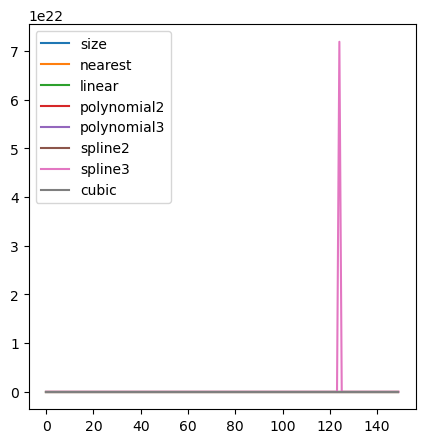

In [121]:
plt.figure(figsize=(5,5))
plt.plot(test_result2)
plt.legend(test_result2.columns)
plt.show()

In [123]:
test_result2.columns

Index(['size', 'nearest', 'linear', 'polynomial2', 'polynomial3', 'spline2',
       'spline3', 'cubic'],
      dtype='object')

In [129]:
test_result2[['size', 'nearest', 'linear', 'polynomial2', 'polynomial3', 'spline2', 'cubic']]

,size,nearest,linear,polynomial2,polynomial3,spline2,cubic
0,0.01,207.07,125.24,134.02,137.38,133.92,137.38
1,0.02,236.95,162.63,193.05,193.70,202.63,193.70
2,0.03,273.20,158.38,197.88,207.59,207.52,207.59
3,0.04,314.31,194.03,255.94,263.61,255.47,263.61
4,0.05,375.76,216.80,300.05,306.13,300.01,306.13
...,...,...,...,...,...,...,...
145,1.46,3809.26,3216.07,5623.60,9709.85,5625.46,9709.85
146,1.47,3493.70,2876.99,5829.08,6011.40,5819.36,6011.40
147,1.48,3688.09,2991.35,5914.62,10555.12,6235.71,10555.12
148,1.49,3755.10,3141.52,5952.31,9696.67,6070.45,9696.67


### spline(order=3)의 값을 제외하고 다시 시각화
- 여전히 linear한 방법의 보간이 가장 좋은 성능을 보임(전구간)
- 원래는 이 데이터를 통해서 기울기가 급격히 커지는 지점을 찾고, 그 구간을 기준점으로 기준점보다 낮은 연속 결측치의 경우 가장 좋은 성능의 보간법을 사용하고
- 기준점 이상의 연속 결측치의 경우, 다른 방법을 적용하고자 했음
- 그러나 다소 선형적인 형태를 보여, 이 방법은 어려울 것으로 보임
- 연속 결측치의 보간 방법 기준점을 임의로 설정할 수 밖에 없을 것으로 보임

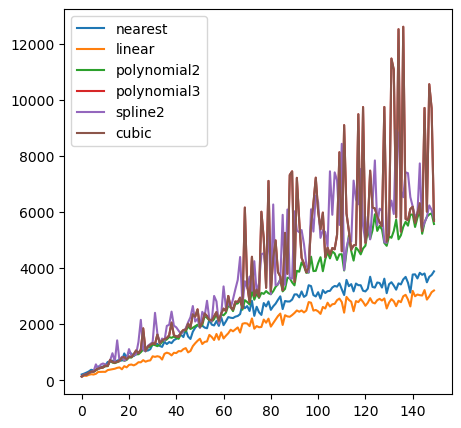

In [131]:
plt.figure(figsize=(5,5))
plt.plot(test_result2[['nearest', 'linear', 'polynomial2', 'polynomial3', 'spline2', 'cubic']])
plt.legend(test_result2[['nearest', 'linear', 'polynomial2', 'polynomial3', 'spline2', 'cubic']].columns)
plt.show()

## 2022년 4월 28일 데이터 채우기

### 데이터 확인

- 실제 데이터와 EPSIS에서 가져온 데이터에 0.6 미만의 오차가 있는 것을 확인

In [9]:
pd_220428_ori = elec_demand.loc['2022-04-28'].reset_index()

In [10]:
pd_220428 = pd.read_csv('./data/20220428_power_demand.csv')

In [11]:
pd_220428

,현재수요(MW)
0,59212
1,59248
2,58913
3,58591
4,58306
...,...
283,61016
284,60570
285,60449
286,60220


In [12]:
pd_220428_ori['epsis'] = pd_220428['현재수요(MW)']

In [13]:
pd_220428_ori['diff'] = pd_220428_ori['현재수요(MW)'] - pd_220428_ori['epsis']

In [14]:
pd_220428_ori['diff'].max()

0.5999999999985448

### 2022년 4월 28일의 데이터를 채움 

In [15]:
idx = elec_demand.loc['2022-04-28'].index

In [16]:
elec_demand.loc['2022-04-28']

,현재수요(MW),day
기준일시,,
2022-04-28 00:00:00,NaN,2022-04-28
2022-04-28 00:05:00,NaN,2022-04-28
2022-04-28 00:10:00,NaN,2022-04-28
2022-04-28 00:15:00,NaN,2022-04-28
2022-04-28 00:20:00,NaN,2022-04-28
...,...,...
2022-04-28 23:35:00,61016.5,2022-04-28
2022-04-28 23:40:00,60570.1,2022-04-28
2022-04-28 23:45:00,60448.7,2022-04-28


In [17]:
pd_220428 = pd_220428.set_index(idx)

In [18]:
elec_demand.loc['2022-04-28', '현재수요(MW)'] = pd_220428['현재수요(MW)']

In [19]:
elec_demand.loc['2022-04-28', '현재수요(MW)']

기준일시
2022-04-28 00:00:00    59212.0
2022-04-28 00:05:00    59248.0
2022-04-28 00:10:00    58913.0
2022-04-28 00:15:00    58591.0
2022-04-28 00:20:00    58306.0
                        ...   
2022-04-28 23:35:00    61016.0
2022-04-28 23:40:00    60570.0
2022-04-28 23:45:00    60449.0
2022-04-28 23:50:00    60220.0
2022-04-28 23:55:00    59727.0
Name: 현재수요(MW), Length: 288, dtype: float64

In [20]:
idx = elec_demand.index

In [21]:
elec_demand = elec_demand.reset_index()
elec_demand['weekday'] = elec_demand['기준일시'].dt.weekday
elec_demand = elec_demand.set_index('기준일시')
elec_demand

,현재수요(MW),day,weekday
기준일시,,,
2012-06-01 00:00:00,51726.33,2012-06-01,4
2012-06-01 00:05:00,51342.53,2012-06-01,4
2012-06-01 00:10:00,51583.17,2012-06-01,4
2012-06-01 00:15:00,51631.69,2012-06-01,4
2012-06-01 00:20:00,51252.66,2012-06-01,4
...,...,...,...
2023-03-20 23:35:00,64475.60,2023-03-20,0
2023-03-20 23:40:00,64211.80,2023-03-20,0
2023-03-20 23:45:00,63576.80,2023-03-20,0


In [23]:
list = []
for date in missing_days:
    tmp_dict = {}
    data = checkConsNaN(elec_demand, date)
    tmp_dict['date'] = data[0]
    tmp_dict['totalNa'] = data[1] + data[2]
    tmp_dict['consecutive'] = data[1]
    tmp_dict['inconsecutive'] = data[2]

    list.append(tmp_dict)

missing_cons = pd.DataFrame(list)
missing_cons

,date,totalNa,consecutive,inconsecutive
0,2022-04-28,0,0,0
1,2022-04-06,124,112,12
2,2022-04-27,121,110,11
3,2022-08-16,71,64,7
4,2023-02-17,41,14,27
...,...,...,...,...
724,2019-07-27,1,0,1
725,2019-06-21,1,0,1
726,2019-05-17,1,0,1
727,2019-01-19,1,0,1


In [29]:
missing_dates = missing_cons['date']
missing_cons_consecutive = missing_cons[missing_cons['consecutive']>0]['consecutive']

In [33]:
test_target = missing_cons_consecutive.sort_values().unique()
test_target

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  17,  29,  34,  64, 110, 112], dtype=int64)

In [42]:
elec_demand['day'][0]

'2012-06-01'

In [43]:
import matplotlib as plt

In [44]:
elec_demand.reset_index().groupby('weekday').agg({'현재수요(MW)':'mean'})

,현재수요(MW)
weekday,
0,63021.737013
1,64892.442864
2,64873.268552
3,65055.388993
4,64529.015718
5,58573.157420
6,54654.075629


In [70]:
from datetime import timedelta

In [73]:
str(pd.to_datetime(elec_demand['day'])[0] - timedelta(days=1)).split(' ')[0]

'2012-05-31'

In [206]:
aa = pd.DataFrame([{1:1, 2:2, 3:np.nan, 4:4}, {1:1, 2:np.nan, 3:4, 4:4}, {1:1, 2:np.nan, 3:np.nan, 4:4}, {1:1, 2:np.nan, 3:np.nan, 4:4}])
aa

,1,2,3,4
0,1,2.0,NaN,4
1,1,NaN,4.0,4
2,1,NaN,NaN,4
3,1,NaN,NaN,4


In [210]:
aa[2].fillna(method='ffill')

0    2.0
1    2.0
2    2.0
3    2.0
Name: 2, dtype: float64

In [295]:
def mean_around(original_df, test_df, start_index, end_index):

    weekday = test_df['weekday'][0]

    reference_dates = {'prev_day':'', 'next_day':'', 'prev_week':'', 'next_week':''}

    original_df['현재수요(MW)'] = original_df[['현재수요(MW)']].interpolate(method='linear')['현재수요(MW)']

    if weekday in (5, 6):
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]

        test_df = test_df.loc[start_index:end_index]
        test_df['prev_week'] = original_df[original_df['day'] == reference_dates['prev_week']].reset_index()['현재수요(MW)']
        test_df['next_week'] = original_df[original_df['day'] == reference_dates['next_week']].reset_index()['현재수요(MW)']

        test_df['mean_around'] = test_df[['prev_week', 'next_week']].mean(axis=1)

        return test_df[['mean_around', 'real_value']]

    elif weekday in (1, 2, 3):
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=1)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=1)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]

    elif weekday == 0:
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=3)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=1)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]
    
    elif weekday == 4:
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=1)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=3)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]

    test_df = test_df.loc[start_index:end_index]
    test_df['prev_day'] = original_df[original_df['day'] == reference_dates['prev_day']].reset_index()['현재수요(MW)']
    test_df['next_day'] = original_df[original_df['day'] == reference_dates['next_day']].reset_index()['현재수요(MW)']
    test_df['prev_week'] = original_df[original_df['day'] == reference_dates['prev_week']].reset_index()['현재수요(MW)']
    test_df['next_week'] = original_df[original_df['day'] == reference_dates['next_week']].reset_index()['현재수요(MW)']

    test_df['mean_around'] = test_df[['prev_day', 'next_day', 'prev_week', 'next_week']].mean(axis=1)

    return test_df[['mean_around', 'real_value']]

def median_around(original_df, test_df, start_index, end_index):

    weekday = test_df['weekday'][0]

    reference_dates = {'prev_day':'', 'next_day':'', 'prev_week':'', 'next_week':''}

    original_df['현재수요(MW)'] = original_df[['현재수요(MW)']].interpolate(method='linear')['현재수요(MW)']

    if weekday in (5, 6):
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]

        test_df = test_df.loc[start_index:end_index]
        test_df['prev_week'] = original_df[original_df['day'] == reference_dates['prev_week']].reset_index()['현재수요(MW)']
        test_df['next_week'] = original_df[original_df['day'] == reference_dates['next_week']].reset_index()['현재수요(MW)']

        test_df['median_around'] = test_df[['prev_week', 'next_week']].median(axis=1)

        return test_df[['median_around', 'real_value']]

    elif weekday in (1, 2, 3):
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=1)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=1)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]

    elif weekday == 0:
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=3)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=1)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]
    
    elif weekday == 4:
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=1)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=3)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]

    test_df = test_df.loc[start_index:end_index]
    test_df['prev_day'] = original_df[original_df['day'] == reference_dates['prev_day']].reset_index()['현재수요(MW)']
    test_df['next_day'] = original_df[original_df['day'] == reference_dates['next_day']].reset_index()['현재수요(MW)']
    test_df['prev_week'] = original_df[original_df['day'] == reference_dates['prev_week']].reset_index()['현재수요(MW)']
    test_df['next_week'] = original_df[original_df['day'] == reference_dates['next_week']].reset_index()['현재수요(MW)']

    test_df['median_around'] = test_df[['prev_day', 'next_day', 'prev_week', 'next_week']].median(axis=1)

    return test_df[['median_around', 'real_value']]
def nearest_around(original_df, test_df, start_index, end_index):

    from sklearn.metrics import mean_squared_error

    weekday = test_df['weekday'][0]

    reference_dates = {'prev_day':'', 'next_day':'', 'prev_week':'', 'next_week':''}

    original_df['현재수요(MW)'] = original_df[['현재수요(MW)']].interpolate(method='linear')['현재수요(MW)']

    if weekday in (5, 6):
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]

        test_df = test_df.loc[start_index:end_index]
        test_df['prev_week'] = original_df[original_df['day'] == reference_dates['prev_week']].reset_index()['현재수요(MW)']
        test_df['next_week'] = original_df[original_df['day'] == reference_dates['next_week']].reset_index()['현재수요(MW)']

        check_df = pd.concat([test_df.loc[:start_index], test_df[end_index:]])
        check_df['prev_week'] = original_df[original_df['day'] == reference_dates['prev_week']].reset_index()['현재수요(MW)']
        check_df['next_week'] = original_df[original_df['day'] == reference_dates['next_week']].reset_index()['현재수요(MW)']

        mse_prev = mean_squared_error(check_df['real_value'], check_df['prev_week'])
        mse_next = mean_squared_error(check_df['real_value'], check_df['next_week'])

        min_val = min(mse_prev, mse_next)

        if mse_prev == min_val:
            test_df['nearest_around'] = test_df['prev_week']

        elif mse_next == min_val:
            test_df['nearest_around'] = test_df['next_week']

        return test_df[['nearest_around', 'real_value']]

    elif weekday in (1, 2, 3):
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=1)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=1)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]

    elif weekday == 0:
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=3)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=1)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]
    
    elif weekday == 4:
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=1)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=3)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]

    test_df = test_df.loc[start_index:end_index]
    test_df['prev_day'] = original_df[original_df['day'] == reference_dates['prev_day']].reset_index()['현재수요(MW)']
    test_df['next_day'] = original_df[original_df['day'] == reference_dates['next_day']].reset_index()['현재수요(MW)']
    test_df['prev_week'] = original_df[original_df['day'] == reference_dates['prev_week']].reset_index()['현재수요(MW)']
    test_df['next_week'] = original_df[original_df['day'] == reference_dates['next_week']].reset_index()['현재수요(MW)']

    check_df = pd.concat([test_df.loc[:start_index], test_df[end_index:]])
    check_df['prev_day'] = original_df[original_df['day'] == reference_dates['prev_day']].reset_index()['현재수요(MW)']
    check_df['next_day'] = original_df[original_df['day'] == reference_dates['next_day']].reset_index()['현재수요(MW)']
    check_df['prev_week'] = original_df[original_df['day'] == reference_dates['prev_week']].reset_index()['현재수요(MW)']
    check_df['next_week'] = original_df[original_df['day'] == reference_dates['next_week']].reset_index()['현재수요(MW)']

    mse_prev_day = mean_squared_error(check_df['real_value'], check_df['prev_day'])
    mse_next_day = mean_squared_error(check_df['real_value'], check_df['next_day'])
    mse_prev_week = mean_squared_error(check_df['real_value'], check_df['prev_week'])
    mse_next_week = mean_squared_error(check_df['real_value'], check_df['next_week'])

    min_val = np.min([mse_prev_day, mse_next_day, mse_prev_week, mse_next_week])

    if mse_prev_day == min_val:
        test_df['nearest_around'] = test_df['prev_day']

    elif mse_next_day == min_val:
        test_df['nearest_around'] = test_df['next_day']

    elif mse_prev_week == min_val:
        test_df['nearest_around'] = test_df['prev_week']

    elif mse_next_week == min_val:
        test_df['nearest_around'] = test_df['next_week']

    return test_df[['nearest_around', 'real_value']]

In [294]:
import warnings
from sklearn.metrics import mean_squared_error
warnings.filterwarnings(action='ignore')

In [273]:
import numpy as np
import pandas as pd
score_list = []
for size in range(150):
    score = {'size':size+1,'linear':0, 'mean_around':0, 'median_around':0, 'nearest_around':0}
    for iteration in range(100):
        not_null_sample = count[count['현재수요(MW)'] == 288].index
        not_null_sample = not_null_sample.drop(not_null_sample[:5])
        not_null_sample = not_null_sample.drop(not_null_sample[-6:])
        not_null_sample1 = np.random.choice(not_null_sample, 1)
        sample100 = elec_demand[elec_demand['day'].isin(not_null_sample1)]
        sample100['real_value'] = sample100['현재수요(MW)'].copy()
        sample100.rename(columns={'현재수요(MW)':'gen_null'}, inplace=True)
        sample100 = sample100.reset_index(drop=True)

        print(not_null_sample1)

        # Randomly select the starting index for consecutive NaN values
        start_index = np.random.randint(1, len(sample100)-size-2)

        # Determine the length of consecutive NaN values
        consecutive_nan_lengths = size 

        # Set consecutive NaN values at the randomly chosen indices
        end_index = start_index + consecutive_nan_lengths

        sample100.loc[start_index:end_index, 'gen_null'] = np.nan

        print(start_index, end_index)

        for method in ['linear', 'mean_around', 'median_around', 'nearest_around']:
            if method == 'linear':
                sample100[method] = sample100[['gen_null']].interpolate(method=method).rename(columns={"gen_null":method})[method]

                score[method] += np.sqrt(mean_squared_error(sample100.loc[start_index:end_index, 'real_value'],
                                                            sample100.loc[start_index:end_index, method]))
            elif method == 'mean_around':
                sample100[method] = mean_around(elec_demand, sample100, start_index, end_index)[method]

                score[method] += np.sqrt(mean_squared_error(sample100.loc[start_index:end_index, 'real_value'],
                                                            sample100.loc[start_index:end_index, method]))
                
            elif method == 'median_around':
                sample100[method] = median_around(elec_demand, sample100, start_index, end_index)[method]


                score[method] += np.sqrt(mean_squared_error(sample100.loc[start_index:end_index, 'real_value'],
                                                            sample100.loc[start_index:end_index, method]))
                
            elif method == 'nearest_around':
                sample100[method] = nearest_around(elec_demand, sample100, start_index, end_index)[method]

                score[method] += np.sqrt(mean_squared_error(sample100.loc[start_index:end_index, 'real_value'],
                                                            sample100.loc[start_index:end_index, method]))
                        
    print(score)
    score_list.append(score)


['2013-10-10']
142 142
['2017-02-26']
185 185
['2021-09-06']
178 178
['2016-06-14']
183 183
['2018-07-09']
241 241
['2012-12-13']
8 8
['2022-06-23']
182 182
['2017-12-05']
90 90
['2020-09-15']
277 277
['2021-04-17']
68 68
['2014-11-30']
145 145
['2019-07-19']
269 269
['2014-11-02']
104 104
['2018-02-10']
229 229
['2019-08-03']
58 58
['2016-10-13']
237 237
['2022-07-20']
79 79
['2018-05-26']
215 215
['2021-04-09']
78 78
['2012-06-27']
268 268
['2015-06-01']
112 112
['2019-12-05']
20 20
['2016-03-02']
245 245
['2017-04-23']
277 277
['2020-06-07']
77 77
['2020-04-18']
80 80
['2012-07-06']
33 33
['2015-12-06']
206 206
['2020-09-20']
188 188
['2015-05-07']
135 135
['2022-01-07']
82 82
['2015-04-06']
70 70
['2015-05-31']
271 271
['2020-09-16']
163 163
['2021-07-26']
104 104
['2014-03-06']
194 194
['2012-08-20']
259 259
['2013-05-22']
2 2
['2013-01-18']
170 170
['2021-04-29']
83 83
['2013-01-26']
273 273
['2012-12-29']
44 44
['2019-02-07']
138 138
['2018-01-08']
66 66
['2015-01-04']
29 29
['2

KeyboardInterrupt: 

In [274]:
score_list

[{'size': 1,
  'linear': 11074.475000000042,
  'mean_around': 189348.0950000001,
  'median_around': 178666.17000000007,
  'nearest_around': 93385.90000000005},
 {'size': 2,
  'linear': 14470.516955450857,
  'mean_around': 193899.75301757932,
  'median_around': 182715.18413744477,
  'nearest_around': 97980.80145903732},
 {'size': 3,
  'linear': 15908.367784645676,
  'mean_around': 215613.0819198596,
  'median_around': 203893.39428358668,
  'nearest_around': 81862.0734986617},
 {'size': 4,
  'linear': 20014.266318455768,
  'mean_around': 220001.55095307436,
  'median_around': 227311.96833083502,
  'nearest_around': 125994.73557051773},
 {'size': 5,
  'linear': 21283.923989435734,
  'mean_around': 184202.3515735952,
  'median_around': 170439.61869206707,
  'nearest_around': 106957.57036937092}]

In [296]:
import numpy as np
import pandas as pd
score_list = []
for size in range(150, 1, -10):
    score = {'size':size+1,'linear':0, 'mean_around':0, 'median_around':0, 'nearest_around':0}
    for iteration in range(100):
        not_null_sample = count[count['현재수요(MW)'] == 288].index
        not_null_sample = not_null_sample.drop(not_null_sample[:5])
        not_null_sample = not_null_sample.drop(not_null_sample[-6:])
        not_null_sample1 = np.random.choice(not_null_sample, 1)
        sample100 = elec_demand[elec_demand['day'].isin(not_null_sample1)]
        sample100['real_value'] = sample100['현재수요(MW)'].copy()
        sample100.rename(columns={'현재수요(MW)':'gen_null'}, inplace=True)
        sample100 = sample100.reset_index(drop=True)

        print(not_null_sample1)

        # Randomly select the starting index for consecutive NaN values
        start_index = np.random.randint(1, len(sample100)-size-2)

        # Determine the length of consecutive NaN values
        consecutive_nan_lengths = size 

        # Set consecutive NaN values at the randomly chosen indices
        end_index = start_index + consecutive_nan_lengths

        sample100.loc[start_index:end_index, 'gen_null'] = np.nan

        print(start_index, end_index)

        for method in ['linear', 'mean_around', 'median_around', 'nearest_around']:
            if method == 'linear':
                sample100[method] = sample100[['gen_null']].interpolate(method=method).rename(columns={"gen_null":method})[method]

                score[method] += np.sqrt(mean_squared_error(sample100.loc[start_index:end_index, 'real_value'],
                                                            sample100.loc[start_index:end_index, method]))
            elif method == 'mean_around':
                sample100[method] = mean_around(elec_demand, sample100, start_index, end_index)[method]

                score[method] += np.sqrt(mean_squared_error(sample100.loc[start_index:end_index, 'real_value'],
                                                            sample100.loc[start_index:end_index, method]))
                
            elif method == 'median_around':
                sample100[method] = median_around(elec_demand, sample100, start_index, end_index)[method]


                score[method] += np.sqrt(mean_squared_error(sample100.loc[start_index:end_index, 'real_value'],
                                                            sample100.loc[start_index:end_index, method]))
                
            elif method == 'nearest_around':
                sample100[method] = nearest_around(elec_demand, sample100, start_index, end_index)[method]

                score[method] += np.sqrt(mean_squared_error(sample100.loc[start_index:end_index, 'real_value'],
                                                            sample100.loc[start_index:end_index, method]))
                        
    print(score)
    score_list.append(score)


['2019-03-06']
79 229
['2020-11-07']
29 179
['2018-09-03']
64 214
['2016-01-28']
56 206
['2015-12-17']
32 182
['2014-10-07']
104 254
['2019-05-26']
107 257
['2012-10-18']
13 163
['2014-11-12']
2 152
['2020-07-14']
52 202
['2018-02-06']
128 278
['2018-05-02']
29 179
['2016-10-03']
135 285
['2015-01-05']
32 182
['2019-03-29']
52 202
['2018-04-23']
8 158
['2015-07-10']
2 152
['2014-05-15']
86 236
['2022-10-23']
13 163
['2022-11-15']
7 157
['2019-07-15']
92 242
['2016-11-02']
88 238
['2022-09-13']
70 220
['2012-11-09']
125 275
['2019-05-05']
60 210
['2020-01-14']
128 278
['2016-03-11']
20 170
['2018-01-29']
6 156
['2019-03-09']
48 198
['2021-09-17']
10 160
['2019-06-24']
89 239
['2017-03-19']
110 260
['2013-05-13']
81 231
['2016-03-20']
118 268
['2013-10-16']
71 221
['2022-04-17']
69 219
['2019-05-27']
122 272
['2021-04-01']
21 171
['2022-03-05']
124 274
['2018-11-08']
62 212
['2014-05-03']
56 206
['2021-09-27']
105 255
['2019-11-20']
127 277
['2015-05-14']
5 155
['2022-10-29']
119 269
['2

In [297]:
test_result2 = pd.DataFrame(score_list)
test_result2

,size,linear,mean_around,median_around,nearest_around
0,151,318759.103152,204302.874307,190616.237233,175165.145933
1,141,321547.512349,230057.081426,216977.709909,174400.851933
2,131,293093.478579,227018.979392,225121.368872,222928.379139
3,121,276523.490593,227292.460464,212851.405441,184428.005410
4,111,271821.906835,194263.998983,175350.482407,162769.799718
5,101,279709.623447,213060.124970,201903.300739,167430.775273
6,91,232988.130472,234711.737129,234461.758170,177082.497885
7,81,214859.433854,205445.679737,192766.990069,138248.593569
8,71,184479.409515,175885.825546,160545.497520,150858.650352
9,61,171418.173295,188986.349965,189232.609616,136616.134306


In [333]:
def mean_around(original_df, test_df, start_index, end_index):

    weekday = test_df['weekday'][0]

    reference_dates = {'prev_day':'', 'next_day':'', 'prev_week':'', 'next_week':''}

    original_df['현재수요(MW)'] = original_df[['현재수요(MW)']].interpolate(method='linear')['현재수요(MW)']


    if weekday in (5, 6):
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]

        weight_prev_week = original_df[original_df['day'] == test_df['day'][0]].reset_index().loc[start_index-1,'현재수요(MW)'] / original_df[original_df['day'] == reference_dates['prev_week']].reset_index().loc[start_index-1,'현재수요(MW)']
        weight_next_week = original_df[original_df['day'] == test_df['day'][0]].reset_index().loc[start_index-1,'현재수요(MW)'] / original_df[original_df['day'] == reference_dates['next_week']].reset_index().loc[start_index-1,'현재수요(MW)']

        test_df = test_df.loc[start_index:end_index]

        test_df['prev_week'] = original_df[original_df['day'] == reference_dates['prev_week']].reset_index()['현재수요(MW)'] * weight_prev_week
        test_df['next_week'] = original_df[original_df['day'] == reference_dates['next_week']].reset_index()['현재수요(MW)'] * weight_next_week

        test_df['mean_around'] = test_df[['prev_week', 'next_week']].mean(axis=1)

        return test_df[['mean_around', 'real_value']]

    elif weekday in (1, 2, 3):
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=1)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=1)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]

    elif weekday == 0:
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=3)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=1)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]
    
    elif weekday == 4:
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=1)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=3)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]

    weight_prev_day = original_df[original_df['day'] == test_df['day'][0]].reset_index().loc[start_index-1,'현재수요(MW)'] / original_df[original_df['day'] == reference_dates['prev_day']].reset_index().loc[start_index-1,'현재수요(MW)']
    weight_next_day = original_df[original_df['day'] == test_df['day'][0]].reset_index().loc[start_index-1,'현재수요(MW)'] / original_df[original_df['day'] == reference_dates['next_day']].reset_index().loc[start_index-1,'현재수요(MW)']
    weight_prev_week = original_df[original_df['day'] == test_df['day'][0]].reset_index().loc[start_index-1,'현재수요(MW)'] / original_df[original_df['day'] == reference_dates['prev_week']].reset_index().loc[start_index-1,'현재수요(MW)']
    weight_next_week = original_df[original_df['day'] == test_df['day'][0]].reset_index().loc[start_index-1,'현재수요(MW)'] / original_df[original_df['day'] == reference_dates['next_week']].reset_index().loc[start_index-1,'현재수요(MW)']


    test_df = test_df.loc[start_index:end_index]
    test_df['prev_day'] = original_df[original_df['day'] == reference_dates['prev_day']].reset_index()['현재수요(MW)'] * weight_prev_day
    test_df['next_day'] = original_df[original_df['day'] == reference_dates['next_day']].reset_index()['현재수요(MW)'] * weight_next_day
    test_df['prev_week'] = original_df[original_df['day'] == reference_dates['prev_week']].reset_index()['현재수요(MW)'] * weight_prev_week
    test_df['next_week'] = original_df[original_df['day'] == reference_dates['next_week']].reset_index()['현재수요(MW)'] * weight_next_week

    test_df['mean_around'] = test_df[['prev_day', 'next_day', 'prev_week', 'next_week']].mean(axis=1)

    return test_df[['mean_around', 'real_value']]


def median_around(original_df, test_df, start_index, end_index):

    weekday = test_df['weekday'][0]

    reference_dates = {'prev_day':'', 'next_day':'', 'prev_week':'', 'next_week':''}

    original_df['현재수요(MW)'] = original_df[['현재수요(MW)']].interpolate(method='linear')['현재수요(MW)']

    if weekday in (5, 6):
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]
        
        weight_prev_week = original_df[original_df['day'] == test_df['day'][0]].reset_index().loc[start_index-1,'현재수요(MW)'] / original_df[original_df['day'] == reference_dates['prev_week']].reset_index().loc[start_index-1,'현재수요(MW)']
        weight_next_week = original_df[original_df['day'] == test_df['day'][0]].reset_index().loc[start_index-1,'현재수요(MW)'] / original_df[original_df['day'] == reference_dates['next_week']].reset_index().loc[start_index-1,'현재수요(MW)']

        test_df = test_df.loc[start_index:end_index]

        test_df['prev_week'] = original_df[original_df['day'] == reference_dates['prev_week']].reset_index()['현재수요(MW)'] * weight_prev_week
        test_df['next_week'] = original_df[original_df['day'] == reference_dates['next_week']].reset_index()['현재수요(MW)'] * weight_next_week

        test_df['median_around'] = test_df[['prev_week', 'next_week']].median(axis=1)

        return test_df[['median_around', 'real_value']]

    elif weekday in (1, 2, 3):
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=1)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=1)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]

    elif weekday == 0:
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=3)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=1)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]
    
    elif weekday == 4:
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=1)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=3)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]

    weight_prev_day = original_df[original_df['day'] == test_df['day'][0]].reset_index().loc[start_index-1,'현재수요(MW)'] / original_df[original_df['day'] == reference_dates['prev_day']].reset_index().loc[start_index-1,'현재수요(MW)']
    weight_next_day = original_df[original_df['day'] == test_df['day'][0]].reset_index().loc[start_index-1,'현재수요(MW)'] / original_df[original_df['day'] == reference_dates['next_day']].reset_index().loc[start_index-1,'현재수요(MW)']
    weight_prev_week = original_df[original_df['day'] == test_df['day'][0]].reset_index().loc[start_index-1,'현재수요(MW)'] / original_df[original_df['day'] == reference_dates['prev_week']].reset_index().loc[start_index-1,'현재수요(MW)']
    weight_next_week = original_df[original_df['day'] == test_df['day'][0]].reset_index().loc[start_index-1,'현재수요(MW)'] / original_df[original_df['day'] == reference_dates['next_week']].reset_index().loc[start_index-1,'현재수요(MW)']

    test_df = test_df.loc[start_index:end_index]

    test_df['prev_day'] = original_df[original_df['day'] == reference_dates['prev_day']].reset_index()['현재수요(MW)'] * weight_prev_day
    test_df['next_day'] = original_df[original_df['day'] == reference_dates['next_day']].reset_index()['현재수요(MW)'] * weight_next_day
    test_df['prev_week'] = original_df[original_df['day'] == reference_dates['prev_week']].reset_index()['현재수요(MW)'] * weight_prev_week
    test_df['next_week'] = original_df[original_df['day'] == reference_dates['next_week']].reset_index()['현재수요(MW)'] * weight_next_week

    test_df['median_around'] = test_df[['prev_day', 'next_day', 'prev_week', 'next_week']].median(axis=1)

    return test_df[['median_around', 'real_value']]


def nearest_around(original_df, test_df, start_index, end_index):

    from sklearn.metrics import mean_squared_error

    weekday = test_df['weekday'][0]

    reference_dates = {'prev_day':'', 'next_day':'', 'prev_week':'', 'next_week':''}

    original_df['현재수요(MW)'] = original_df[['현재수요(MW)']].interpolate(method='linear')['현재수요(MW)']

    if weekday in (5, 6):
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]

        weight_prev_week = original_df[original_df['day'] == test_df['day'][0]].reset_index().loc[start_index-1,'현재수요(MW)'] / original_df[original_df['day'] == reference_dates['prev_week']].reset_index().loc[start_index-1,'현재수요(MW)']
        weight_next_week = original_df[original_df['day'] == test_df['day'][0]].reset_index().loc[start_index-1,'현재수요(MW)'] / original_df[original_df['day'] == reference_dates['next_week']].reset_index().loc[start_index-1,'현재수요(MW)']

        test_df = test_df.loc[start_index:end_index]
        test_df['prev_week'] = original_df[original_df['day'] == reference_dates['prev_week']].reset_index()['현재수요(MW)'] * weight_prev_week
        test_df['next_week'] = original_df[original_df['day'] == reference_dates['next_week']].reset_index()['현재수요(MW)'] * weight_next_week

        check_df = pd.concat([test_df.loc[:start_index], test_df[end_index:]])
        check_df['prev_week'] = original_df[original_df['day'] == reference_dates['prev_week']].reset_index()['현재수요(MW)'] * weight_prev_week
        check_df['next_week'] = original_df[original_df['day'] == reference_dates['next_week']].reset_index()['현재수요(MW)'] * weight_next_week

        mse_prev = mean_squared_error(check_df['real_value'], check_df['prev_week'])
        mse_next = mean_squared_error(check_df['real_value'], check_df['next_week'])

        min_val = min(mse_prev, mse_next)

        if mse_prev == min_val:
            test_df['nearest_around'] = test_df['prev_week']

        elif mse_next == min_val:
            test_df['nearest_around'] = test_df['next_week']

        return test_df[['nearest_around', 'real_value']]

    elif weekday in (1, 2, 3):
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=1)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=1)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]

    elif weekday == 0:
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=3)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=1)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]
    
    elif weekday == 4:
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=1)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=3)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['day'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['day'])[0] + timedelta(days=7)).split(' ')[0]

    weight_prev_day = original_df[original_df['day'] == test_df['day'][0]].reset_index().loc[start_index-1,'현재수요(MW)'] / original_df[original_df['day'] == reference_dates['prev_day']].reset_index().loc[start_index-1,'현재수요(MW)']
    weight_next_day = original_df[original_df['day'] == test_df['day'][0]].reset_index().loc[start_index-1,'현재수요(MW)'] / original_df[original_df['day'] == reference_dates['next_day']].reset_index().loc[start_index-1,'현재수요(MW)']
    weight_prev_week = original_df[original_df['day'] == test_df['day'][0]].reset_index().loc[start_index-1,'현재수요(MW)'] / original_df[original_df['day'] == reference_dates['prev_week']].reset_index().loc[start_index-1,'현재수요(MW)']
    weight_next_week = original_df[original_df['day'] == test_df['day'][0]].reset_index().loc[start_index-1,'현재수요(MW)'] / original_df[original_df['day'] == reference_dates['next_week']].reset_index().loc[start_index-1,'현재수요(MW)']

    test_df = test_df.loc[start_index:end_index]
    test_df['prev_day'] = original_df[original_df['day'] == reference_dates['prev_day']].reset_index()['현재수요(MW)'] * weight_prev_day
    test_df['next_day'] = original_df[original_df['day'] == reference_dates['next_day']].reset_index()['현재수요(MW)'] * weight_next_day
    test_df['prev_week'] = original_df[original_df['day'] == reference_dates['prev_week']].reset_index()['현재수요(MW)'] * weight_prev_week
    test_df['next_week'] = original_df[original_df['day'] == reference_dates['next_week']].reset_index()['현재수요(MW)'] * weight_next_week

    check_df = pd.concat([test_df.loc[:start_index], test_df[end_index:]])
    check_df['prev_day'] = original_df[original_df['day'] == reference_dates['prev_day']].reset_index()['현재수요(MW)'] * weight_prev_day
    check_df['next_day'] = original_df[original_df['day'] == reference_dates['next_day']].reset_index()['현재수요(MW)'] * weight_next_day
    check_df['prev_week'] = original_df[original_df['day'] == reference_dates['prev_week']].reset_index()['현재수요(MW)'] * weight_prev_week
    check_df['next_week'] = original_df[original_df['day'] == reference_dates['next_week']].reset_index()['현재수요(MW)'] * weight_next_week

    mse_prev_day = mean_squared_error(check_df['real_value'], check_df['prev_day'])
    mse_next_day = mean_squared_error(check_df['real_value'], check_df['next_day'])
    mse_prev_week = mean_squared_error(check_df['real_value'], check_df['prev_week'])
    mse_next_week = mean_squared_error(check_df['real_value'], check_df['next_week'])

    min_val = np.min([mse_prev_day, mse_next_day, mse_prev_week, mse_next_week])

    if mse_prev_day == min_val:
        test_df['nearest_around'] = test_df['prev_day']

    elif mse_next_day == min_val:
        test_df['nearest_around'] = test_df['next_day']

    elif mse_prev_week == min_val:
        test_df['nearest_around'] = test_df['prev_week']

    elif mse_next_week == min_val:
        test_df['nearest_around'] = test_df['next_week']

    return test_df[['nearest_around', 'real_value']]

In [334]:
import numpy as np
import pandas as pd
score_list3 = []
for size in range(150, 0, -10):
    score = {'size':size+1,'linear':0, 'mean_around':0, 'median_around':0, 'nearest_around':0}
    for iteration in range(100):
        not_null_sample = count[count['현재수요(MW)'] == 288].index
        not_null_sample = not_null_sample.drop(not_null_sample[:5])
        not_null_sample = not_null_sample.drop(not_null_sample[-6:])
        not_null_sample1 = np.random.choice(not_null_sample, 1)
        sample100 = elec_demand[elec_demand['day'].isin(not_null_sample1)]
        sample100['real_value'] = sample100['현재수요(MW)'].copy()
        sample100.rename(columns={'현재수요(MW)':'gen_null'}, inplace=True)
        sample100 = sample100.reset_index(drop=True)

        print(not_null_sample1)

        # Randomly select the starting index for consecutive NaN values
        start_index = np.random.randint(3, len(sample100)-size-2)

        # Determine the length of consecutive NaN values
        consecutive_nan_lengths = size 

        # Set consecutive NaN values at the randomly chosen indices
        end_index = start_index + consecutive_nan_lengths

        sample100.loc[start_index:end_index, 'gen_null'] = np.nan

        print(start_index, end_index)

        for method in ['linear', 'mean_around', 'median_around', 'nearest_around']:
            if method == 'linear':
                sample100[method] = sample100[['gen_null']].interpolate(method=method).rename(columns={"gen_null":method})[method]

                score[method] += np.sqrt(mean_squared_error(sample100.loc[start_index:end_index, 'real_value'],
                                                            sample100.loc[start_index:end_index, method]))
            elif method == 'mean_around':
                sample100[method] = mean_around(elec_demand, sample100, start_index, end_index)[method]

                score[method] += np.sqrt(mean_squared_error(sample100.loc[start_index:end_index, 'real_value'],
                                                            sample100.loc[start_index:end_index, method]))
                
            elif method == 'median_around':
                sample100[method] = median_around(elec_demand, sample100, start_index, end_index)[method]


                score[method] += np.sqrt(mean_squared_error(sample100.loc[start_index:end_index, 'real_value'],
                                                            sample100.loc[start_index:end_index, method]))
                
            elif method == 'nearest_around':
                sample100[method] = nearest_around(elec_demand, sample100, start_index, end_index)[method]

                score[method] += np.sqrt(mean_squared_error(sample100.loc[start_index:end_index, 'real_value'],
                                                            sample100.loc[start_index:end_index, method]))
  
    print(score)
    score_list3.append(score)

['2019-12-23']
45 195
['2018-06-22']
89 239
['2014-12-19']
95 245
['2018-01-20']
48 198
{'prev_day': '', 'next_day': '', 'prev_week': '2018-01-13', 'next_week': '2018-01-27'}
['2018-09-20']
95 245
['2013-09-01']
130 280
{'prev_day': '', 'next_day': '', 'prev_week': '2013-08-25', 'next_week': '2013-09-08'}
['2018-07-05']
114 264
['2022-08-10']
63 213
['2019-09-28']
39 189
{'prev_day': '', 'next_day': '', 'prev_week': '2019-09-21', 'next_week': '2019-10-05'}
['2019-11-21']
76 226
['2014-06-01']
28 178
{'prev_day': '', 'next_day': '', 'prev_week': '2014-05-25', 'next_week': '2014-06-08'}
['2021-08-10']
28 178
['2014-09-13']
83 233
{'prev_day': '', 'next_day': '', 'prev_week': '2014-09-06', 'next_week': '2014-09-20'}
['2019-11-24']
97 247
{'prev_day': '', 'next_day': '', 'prev_week': '2019-11-17', 'next_week': '2019-12-01'}
['2017-12-23']
20 170
{'prev_day': '', 'next_day': '', 'prev_week': '2017-12-16', 'next_week': '2017-12-30'}
['2013-05-08']
132 282
['2013-10-19']
19 169
{'prev_day': '

In [335]:
test_result2

,size,linear,mean_around,median_around,nearest_around
0,151,318759.103152,204302.874307,190616.237233,175165.145933
1,141,321547.512349,230057.081426,216977.709909,174400.851933
2,131,293093.478579,227018.979392,225121.368872,222928.379139
3,121,276523.490593,227292.460464,212851.405441,184428.005410
4,111,271821.906835,194263.998983,175350.482407,162769.799718
5,101,279709.623447,213060.124970,201903.300739,167430.775273
6,91,232988.130472,234711.737129,234461.758170,177082.497885
7,81,214859.433854,205445.679737,192766.990069,138248.593569
8,71,184479.409515,175885.825546,160545.497520,150858.650352
9,61,171418.173295,188986.349965,189232.609616,136616.134306


In [336]:
test_result3 = pd.DataFrame(score_list3)
test_result3

,size,linear,mean_around,median_around,nearest_around
0,151,328331.055675,183329.144208,181624.036992,229075.419540
1,141,310741.967695,155267.522407,148987.300115,223563.314685
2,131,301737.340532,143531.104560,133387.317468,175106.910896
3,121,265167.073625,140531.596633,138644.887073,168560.233416
4,111,272644.842605,139544.171518,136605.698535,164423.031877
5,101,256303.788816,131562.163845,122528.194819,169731.528862
6,91,253218.475766,109330.538393,104480.112043,144428.577155
7,81,224676.801936,127923.089092,123395.921503,150817.572716
8,71,185225.352478,107864.653286,106140.302251,121332.097469
9,61,158506.584203,103248.830223,103738.641724,133869.398159


---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File c:\Users\jiho\anaconda3\envs\dl-proj-py38\lib\site-packages\pandas\core\indexes\range.py:391, in RangeIndex.get_loc(self, key, method, tolerance)
    390 try:
--> 391     return self._range.index(new_key)
    392 except ValueError as err:

ValueError: 0 is not in range

The above exception was the direct cause of the following exception:

KeyError                                  Traceback (most recent call last)
c:\Users\jiho\Documents\jiho_portfolio\DeepLearning_Project\interpolation.ipynb Cell 97 in <cell line: 4>()
     42 elif method == 'median_around':
---> 43     sample100[method] = median_around(elec_demand, sample100, start_index, end_index)[method]
     44     score[method] += np.sqrt(mean_squared_error(sample100.loc[start_index:end_index, 'real_value'],
     47                                                 sample100.loc[start_index:end_index, method]))

c:\Users\jiho\Documents\jiho_portfolio\DeepLearning_Project\interpolation.ipynb Cell 97 in median_around(original_df, test_df, start_index, end_index)
    102 test_df = test_df.loc[start_index:end_index]
    104 weight_prev_day = original_df[original_df['day'] == test_df['day'][0]].reset_index().loc[start_index-1,'현재수요(MW)'] / original_df[original_df['day'] == reference_dates['prev_day']].reset_index().loc[start_index-1,'현재수요(MW)']
--> 105 weight_next_day = original_df[original_df['day'] == test_df['day'][0]].reset_index().loc[start_index-1,'현재수요(MW)'] / original_df[original_df['day'] == reference_dates['next_day']].reset_index().loc[start_index-1,'현재수요(MW)']
    106 weight_prev_week = original_df[original_df['day'] == test_df['day'][0]].reset_index().loc[start_index-1,'현재수요(MW)'] / original_df[original_df['day'] == reference_dates['prev_week']].reset_index().loc[start_index-1,'현재수요(MW)']
